# CAB420, Encoders and Decoders, Example 3: Semi-Supervised Learning
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we will look at how we can use semi-supervised learning to learn from partial data. Semi-supervised learning works best when you have two tasks, and typically these can be divided into:
* One that is easy to annotate, and you have lots of data for;
* One that is harder to annotate, and so you have less samples.

In my case I'm going to use a reduced classification task were I merge some classes; essentially I'll have a coarse task with full labels, and a fine-grained task with partial labels.

## Too Long; Didn't Read:
* When we use multi-task learning, we don't have to have labels for all tasks for all samples. Instead we can have some (or a lot) of samples for which we have no labels for one task.
* During training, we take note of which training samples we don't have data for and excluded them from the loss calculations. We can do this simply by keeping track of a mask that indicates which samples we do and do not have data for.
* We can also adjust the loss weights to compensate for the lack of data. This means for tasks that we have less data for, we can place a higher weight so that the network still devotes enough energy to that task. We can also use this idea to give tasks different priorities, i.e. some tasks are probably more important than others and the loss weights can reflect that.
* Often in a semi-supervised setting, one of our tasks will be unsupervised (like an autoencoder). I've not done that here, but this can work very well as it means that you can use unlabelled data and agument this with sparse labels.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import model_to_dot, plot_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
import matplotlib.pyplot as plt

import numpy

from sklearn.manifold import TSNE

## The Data
It's fashion MNIST again!

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = numpy.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = numpy.reshape(x_test, (len(x_test), 28, 28, 1))

For my second task, I'm going to create a coarse version of the Fashion MNIST labels. Easily offended fashionistas should look away now, but I'm going to create a three class version of the data as follows:
* Class 0 will be "things that go on the top half of your body", and will contain the following original Fashion MNIST classes:
  * Class 0: T-shirt/top
  * Class 2: Pullover
  * Class 4: Coat
  * Class 6: Shirt
* Class 1 will be "things that cover your legs", and will contain:
  * Class 1: Trouser
  * Class 3: Dress
* Class 2 will then be "the rest", and will include:
  * Class 5: Sandal
  * Class 7: Sneaker
  * Class 8: Bag
  * Class 9: Ankle boot

In [3]:
y_train_simple = numpy.zeros(y_train.shape)
# set samples that are class 1
y_train_simple[y_train == 1] = 1
y_train_simple[y_train == 3] = 1
# set samples that are in class 2
y_train_simple[y_train == 5] = 2
y_train_simple[y_train == 7] = 2
y_train_simple[y_train == 8] = 2
y_train_simple[y_train == 9] = 2
# note that I don't need to set class 0, as the array is initialised to 0's

y_test_simple = numpy.zeros(y_test.shape)
# set samples that are class 1
y_test_simple[y_test == 1] = 1
y_test_simple[y_test == 3] = 1
# set samples that are in class 2
y_test_simple[y_test == 5] = 2
y_test_simple[y_test == 7] = 2
y_test_simple[y_test == 8] = 2
y_test_simple[y_test == 9] = 2

I'll now convert everything to a categorical.

In [4]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train_simple = to_categorical(y_train_simple)
y_test_simple = to_categorical(y_test_simple)

In [5]:
print(y_train)
print(y_train_simple)

[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


From the above, I can see that I've got a 3-class version for my second task.

## The Network

Let's keep it simple. Three Conv2D layers, and then a couple of simple classification heads with two layers each.

In [6]:
def build_network():
    input_img = Input(shape=(28, 28, 1))

    # an encoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # output of the encoder, some dense embedding
    x = Flatten(name='representation')(x)

    # first output (fine-grained task), pass the embedding through a couple of dense layers to
    # get our output
    fine_grained_out = Dense(32, activation='relu')(x)
    fine_grained_out = Dense(10, activation='softmax', name='fine_grained_output')(fine_grained_out)
    
    # second output, same as the first, but with fewer classes
    coarse_out = Dense(32, activation='relu')(x)
    coarse_out = Dense(3, activation='softmax', name='coarse_output')(coarse_out)

    multitask_cnn = Model(input_img, [fine_grained_out, coarse_out])

    return multitask_cnn

## Model 1: All the Data

Let's test that with all the data, just to make sure that it all works before we start shedding data.

Our setup for this is pretty straight forward, we'll:
* Use categorical cross-entropy for our fine-grained loss
* Use categorical cross-entropy for our coarse classification loss

While I'm using the same loss for both tasks here, it's really important to note that I don't have to. Both these tasks are multi-class classification tasks, so categorical cross entropy is the correct loss to use here for both, but the loss functions can be different if the tasks demand it.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 8)    80          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 16)   1168        ['max_pooling2d[0][0]']          
                                                                                              

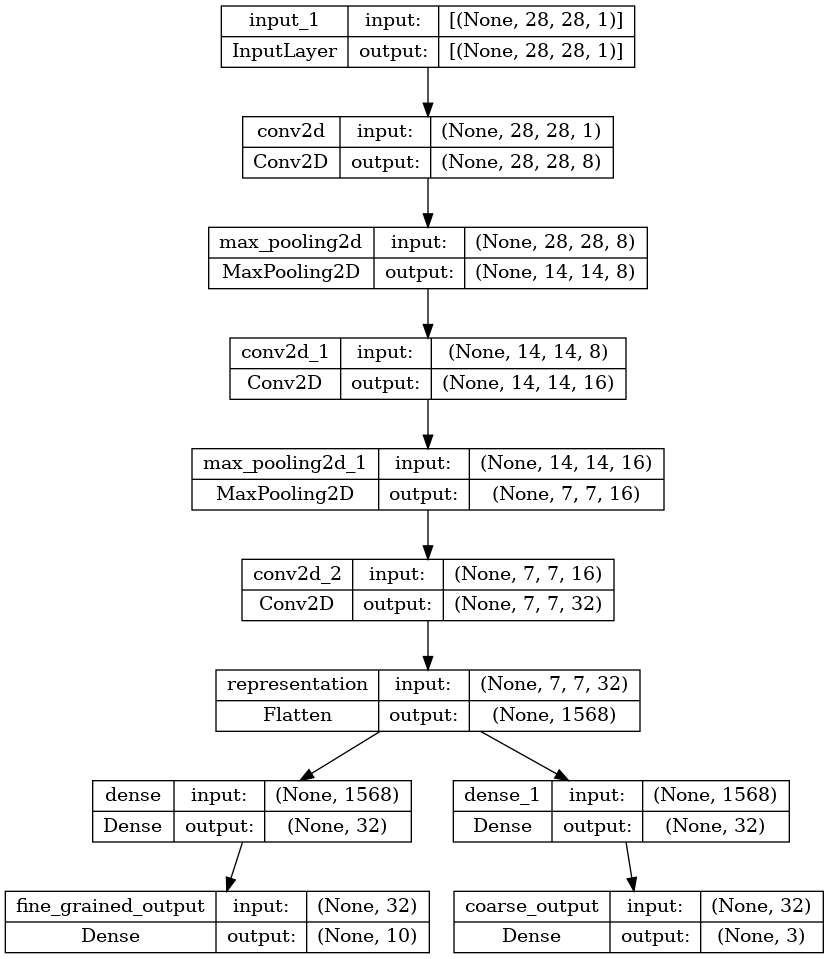

In [7]:
multitask_cnn = build_network()
multitask_cnn.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'])
print(multitask_cnn.summary())
plot_model(multitask_cnn, show_shapes=True)

In [8]:
history = multitask_cnn.fit(x_train, [y_train, y_train_simple],
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, [y_test, y_test_simple]))

Epoch 1/10
938/938 [==============================] - 41s 39ms/step - loss: 0.6697 - fine_grained_output_loss: 0.5437 - coarse_output_loss: 0.1261 - val_loss: 0.4859 - val_fine_grained_output_loss: 0.4012 - val_coarse_output_loss: 0.0847
Epoch 2/10
938/938 [==============================] - 35s 38ms/step - loss: 0.4410 - fine_grained_output_loss: 0.3611 - coarse_output_loss: 0.0798 - val_loss: 0.4349 - val_fine_grained_output_loss: 0.3567 - val_coarse_output_loss: 0.0782
Epoch 3/10
938/938 [==============================] - 38s 41ms/step - loss: 0.3802 - fine_grained_output_loss: 0.3145 - coarse_output_loss: 0.0657 - val_loss: 0.3967 - val_fine_grained_output_loss: 0.3273 - val_coarse_output_loss: 0.0694
Epoch 4/10
938/938 [==============================] - 43s 46ms/step - loss: 0.3425 - fine_grained_output_loss: 0.2849 - coarse_output_loss: 0.0576 - val_loss: 0.3716 - val_fine_grained_output_loss: 0.3098 - val_coarse_output_loss: 0.0618
Epoch 5/10
938/938 [============================

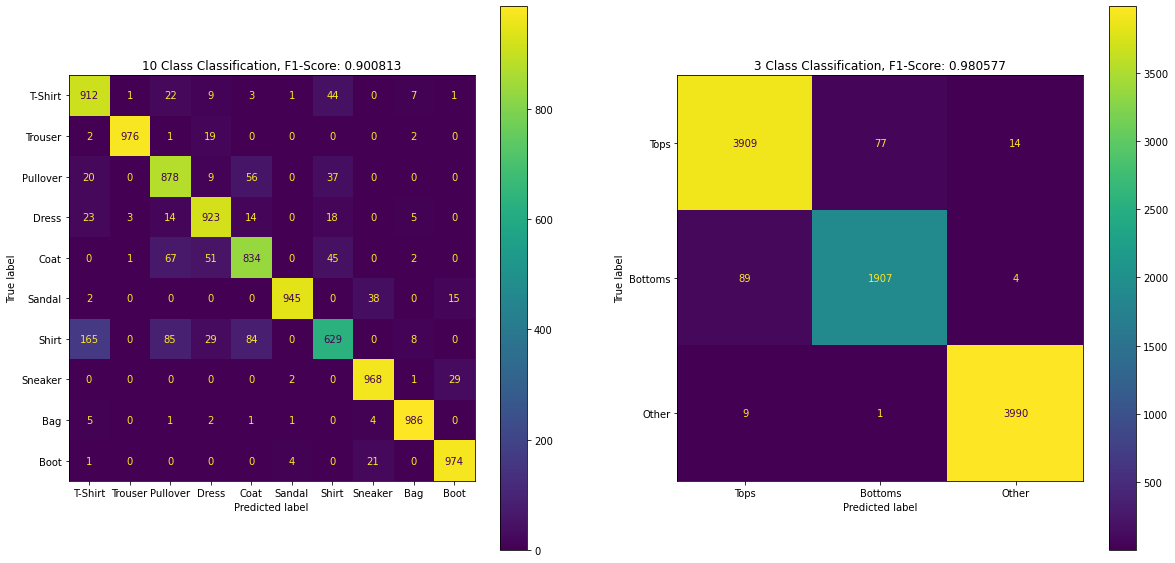

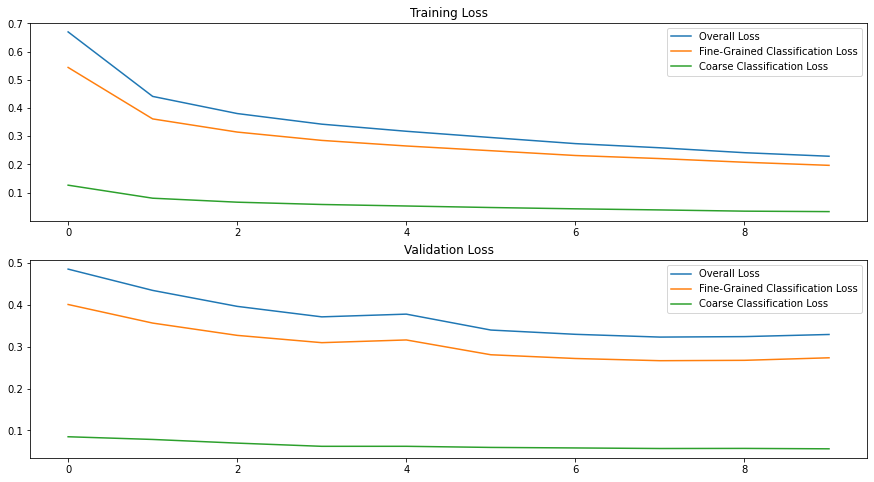

In [9]:
def eval_model(model, x_test, y_test, y_test_simple, history):
    predictions_fine, predictions_coarse = model.predict(x_test, verbose=False);

    indexes = tf.argmax(predictions_fine, axis=1)
    gt = tf.argmax(y_test, axis=1)
    
    cm = confusion_matrix(gt, indexes)
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=['T-Shirt', 'Trouser', 'Pullover', \
                                                   'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot'])
    c.plot(ax = ax)

    ax.set_title('10 Class Classification, F1-Score: %f' % f1_score(gt, indexes, average='weighted'))
    #print(classification_report(gt, indexes))

    indexes = tf.argmax(predictions_coarse, axis=1)
    gt = tf.argmax(y_test_simple, axis=1)
    
    cm = confusion_matrix(gt, indexes)
    ax = fig.add_subplot(1, 2, 2)
    c = ConfusionMatrixDisplay(cm, display_labels=['Tops', 'Bottoms', 'Other'])
    c.plot(ax = ax)
    ax.set_title('3 Class Classification, F1-Score: %f' % f1_score(gt, indexes, average='weighted'))
    
    fig = plt.figure(figsize=[15, 8])
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(history.history['loss'], label = 'Overall Loss')
    ax.plot(history.history['fine_grained_output_loss'], label = 'Fine-Grained Classification Loss')
    ax.plot(history.history['coarse_output_loss'], label = 'Coarse Classification Loss')
    ax.legend()
    ax.set_title('Training Loss')

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(history.history['val_loss'], label = 'Overall Loss')
    ax.plot(history.history['val_fine_grained_output_loss'], label = 'Fine-Grained Classification Loss')
    ax.plot(history.history['val_coarse_output_loss'], label = 'Coarse Classification Loss')
    ax.legend()
    ax.set_title('Validation Loss')
    
eval_model(multitask_cnn, x_test, y_test, y_test_simple, history)

The model works pretty well. Unsurprisingly, the model crushes the coarse classification task. 

## Model 2: Using 25% of the Labels

We're now going to remove a bunch of labels. To do this we:
* pick a "mask value", this is what label we will give to missing values, it should be something that otherwise isn't in the labels. We'll pick -1
* We'll randomly remove 75% of the labels, and replace them with this mask value
* We now need a new loss function to use the mask. That loss function will do the standard categorical cross entropy, but we'll first just find any elements that we have no labels for and remove them, so we only calculte the loss on those that we have values for

In [10]:
# set the mask value. This should be something from outside the existing set of labels
mask_value = -1

# select some elements to mask out
mask_idx = numpy.random.choice(len(y_train), int(len(y_train)*0.75), replace=True)
# copy the array. Note that I use .copy() here. By default python does a "soft copy", i.e. it just creates 
# a pointer to the data. I want to keep an original version of the data in y_train, so I'll use .copy() here
# to do a fully copy of the memory
y_train_masked = y_train.copy()
# set my masked values to -1
y_train_masked[mask_idx] = mask_value
# sanity check time - print out the two and see what happened. 75% of my data should be -1
print(y_train)
print(y_train_masked)

# semi-supervised cateogorical cross entropy loss. This wil find any rows that have a -1 in the labels
# and remove them from consideration
def masked_cce(y_true, y_pred):
    y_true_masked = tf.boolean_mask(y_true, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    y_pred_masked = tf.boolean_mask(y_pred, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    return K.mean(K.categorical_crossentropy(y_true_masked, y_pred_masked))

[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.  0.  0. ...  0.  0.  1.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [-1. -1. -1. ... -1. -1. -1.]]


Now we can pass our reduced data and new loss function into our model for training

In [11]:
multitask_cnn = build_network()
multitask_cnn.compile(optimizer='adam', loss=[masked_cce, 'categorical_crossentropy'])

history = multitask_cnn.fit(x_train, [y_train_masked, y_train_simple],
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, [y_test, y_test_simple]))

Epoch 1/10
938/938 [==============================] - 43s 44ms/step - loss: 0.7455 - fine_grained_output_loss: 0.6153 - coarse_output_loss: 0.1303 - val_loss: 0.5579 - val_fine_grained_output_loss: 0.4688 - val_coarse_output_loss: 0.0890
Epoch 2/10
938/938 [==============================] - 42s 45ms/step - loss: 0.4688 - fine_grained_output_loss: 0.3874 - coarse_output_loss: 0.0815 - val_loss: 0.4660 - val_fine_grained_output_loss: 0.3896 - val_coarse_output_loss: 0.0764
Epoch 3/10
938/938 [==============================] - 44s 47ms/step - loss: 0.4159 - fine_grained_output_loss: 0.3453 - coarse_output_loss: 0.0707 - val_loss: 0.4351 - val_fine_grained_output_loss: 0.3637 - val_coarse_output_loss: 0.0714
Epoch 4/10
938/938 [==============================] - 45s 47ms/step - loss: 0.3742 - fine_grained_output_loss: 0.3123 - coarse_output_loss: 0.0619 - val_loss: 0.4040 - val_fine_grained_output_loss: 0.3347 - val_coarse_output_loss: 0.0693
Epoch 5/10
938/938 [============================

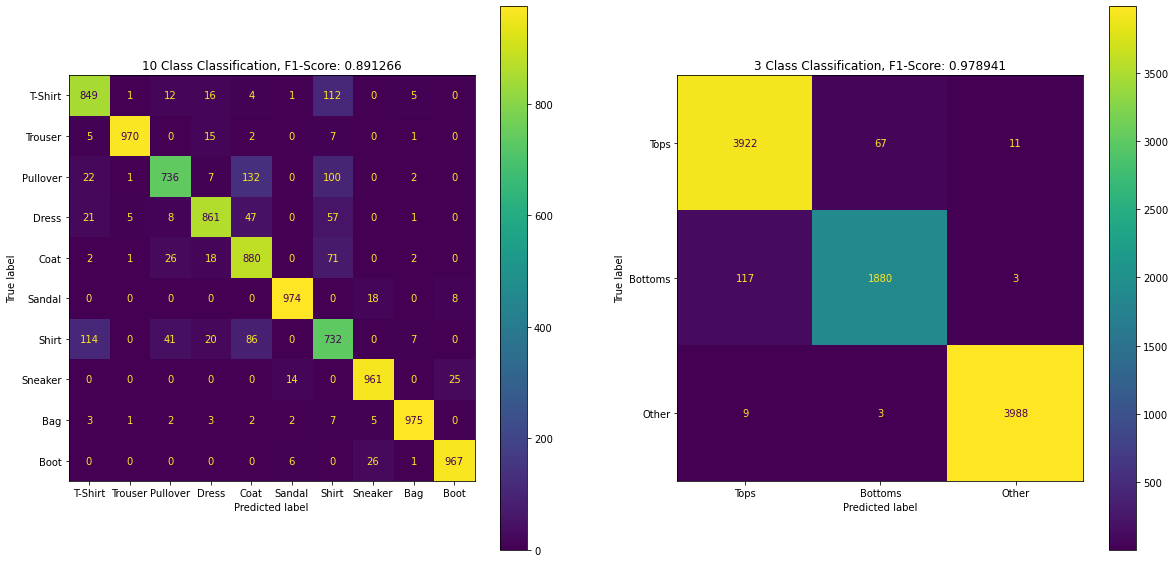

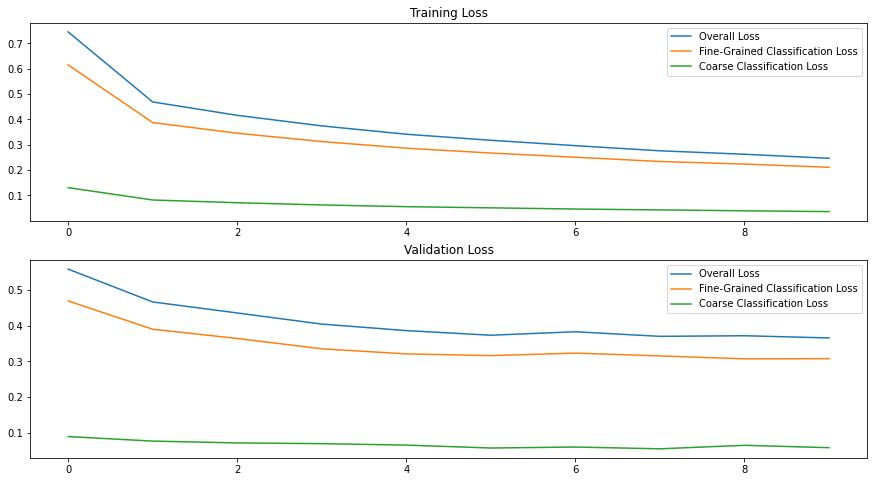

In [12]:
eval_model(multitask_cnn, x_test, y_test, y_test_simple, history)

We see performance is still pretty good. Much the same as last time, but now with much less data.

## Model 2: Using 5% of the Labels

We've thrown away a lot of data now, keeping just 5% of the labels.

In [13]:
mask_idx = numpy.random.choice(len(y_train), int(len(y_train)*0.95), replace=True)
y_train_masked = y_train.copy()
y_train_masked[mask_idx] = mask_value

multitask_cnn = build_network()
multitask_cnn.compile(optimizer='adam', loss=[masked_cce, 'categorical_crossentropy'])

history = multitask_cnn.fit(x_train, [y_train_masked, y_train_simple],
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, [y_test, y_test_simple]))

Epoch 1/10
938/938 [==============================] - 43s 45ms/step - loss: 0.7423 - fine_grained_output_loss: 0.6155 - coarse_output_loss: 0.1268 - val_loss: 0.5646 - val_fine_grained_output_loss: 0.4768 - val_coarse_output_loss: 0.0879
Epoch 2/10
938/938 [==============================] - 43s 46ms/step - loss: 0.4682 - fine_grained_output_loss: 0.3937 - coarse_output_loss: 0.0745 - val_loss: 0.4862 - val_fine_grained_output_loss: 0.4134 - val_coarse_output_loss: 0.0728
Epoch 3/10
938/938 [==============================] - 43s 45ms/step - loss: 0.4017 - fine_grained_output_loss: 0.3386 - coarse_output_loss: 0.0631 - val_loss: 0.4112 - val_fine_grained_output_loss: 0.3443 - val_coarse_output_loss: 0.0669
Epoch 4/10
938/938 [==============================] - 43s 46ms/step - loss: 0.3590 - fine_grained_output_loss: 0.3035 - coarse_output_loss: 0.0554 - val_loss: 0.4237 - val_fine_grained_output_loss: 0.3632 - val_coarse_output_loss: 0.0605
Epoch 5/10
938/938 [============================

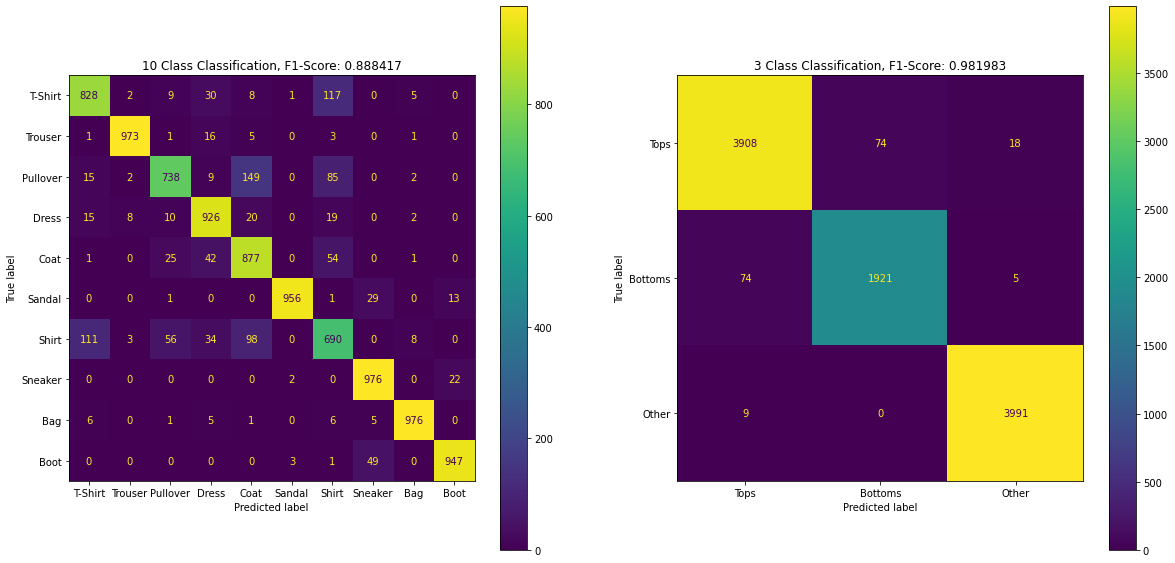

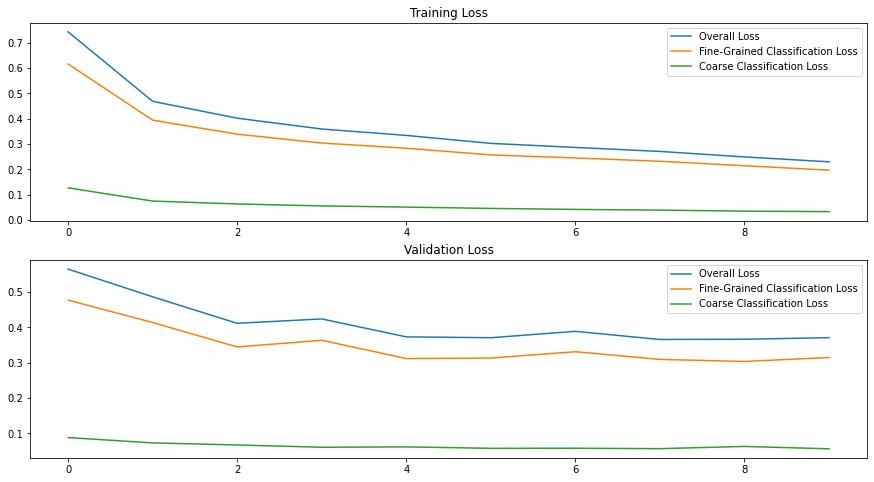

In [14]:
eval_model(multitask_cnn, x_test, y_test, y_test_simple, history)

Again, we see the model works pretty well, with no major drop in performance, despite most of the labels now being missig.

### What of Loss Weights?

Loss weights were discussed above, but we haven't used them here yet. Why not? 

The short answer is we don't need to use them here as we reduce the amount of labels due to the way that out losses are worked out. In some toolkits (and MATLAB is one such toolkit), the total loss is the sum of all the individual losses for each sample, i.e. if we have 10 samples in a batch, the loss is the sum across all of those samples). In Keras, it's the mean of the samples in the batch (have a look at our custom loss function above). That doesn't mean that we can't do it though, or even that we shouldn't.

Here, we only really care about our fine-grained classification task. Our second classification task is really just along for the ride to give us our second task. As such, we'll go again with our first classificaiton loss set to be 10 times that of the second loss.

In [15]:
multitask_cnn = build_network()
multitask_cnn.compile(optimizer='adam', loss=[masked_cce, 'categorical_crossentropy'], loss_weights=[10, 1])

history = multitask_cnn.fit(x_train, [y_train_masked, y_train_simple],
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, [y_test, y_test_simple]))

Epoch 1/10
938/938 [==============================] - 46s 48ms/step - loss: 6.4448 - fine_grained_output_loss: 0.6313 - coarse_output_loss: 0.1315 - val_loss: 4.4140 - val_fine_grained_output_loss: 0.4317 - val_coarse_output_loss: 0.0972
Epoch 2/10
938/938 [==============================] - 44s 47ms/step - loss: 4.0498 - fine_grained_output_loss: 0.3970 - coarse_output_loss: 0.0796 - val_loss: 3.8774 - val_fine_grained_output_loss: 0.3794 - val_coarse_output_loss: 0.0837
Epoch 3/10
938/938 [==============================] - 45s 47ms/step - loss: 3.4679 - fine_grained_output_loss: 0.3399 - coarse_output_loss: 0.0691 - val_loss: 3.6034 - val_fine_grained_output_loss: 0.3533 - val_coarse_output_loss: 0.0703
Epoch 4/10
938/938 [==============================] - 50s 54ms/step - loss: 3.1568 - fine_grained_output_loss: 0.3095 - coarse_output_loss: 0.0621 - val_loss: 3.3669 - val_fine_grained_output_loss: 0.3302 - val_coarse_output_loss: 0.0654
Epoch 5/10
938/938 [============================

When we look at the output from this, we see that the total loss is now the sum of fine_grained_output_loss x 10 + coarse_output_loss. The individual losses are shown as they were before, just the combined loss is changed. 

In our case here this makes no appreciable change in accuracy across the two tasks. This is (most likely) due to the very tightly coupled nature of the tasks. Improve our fine-grained task will directly improve the coarse task, so weighting one over the other has little impact.

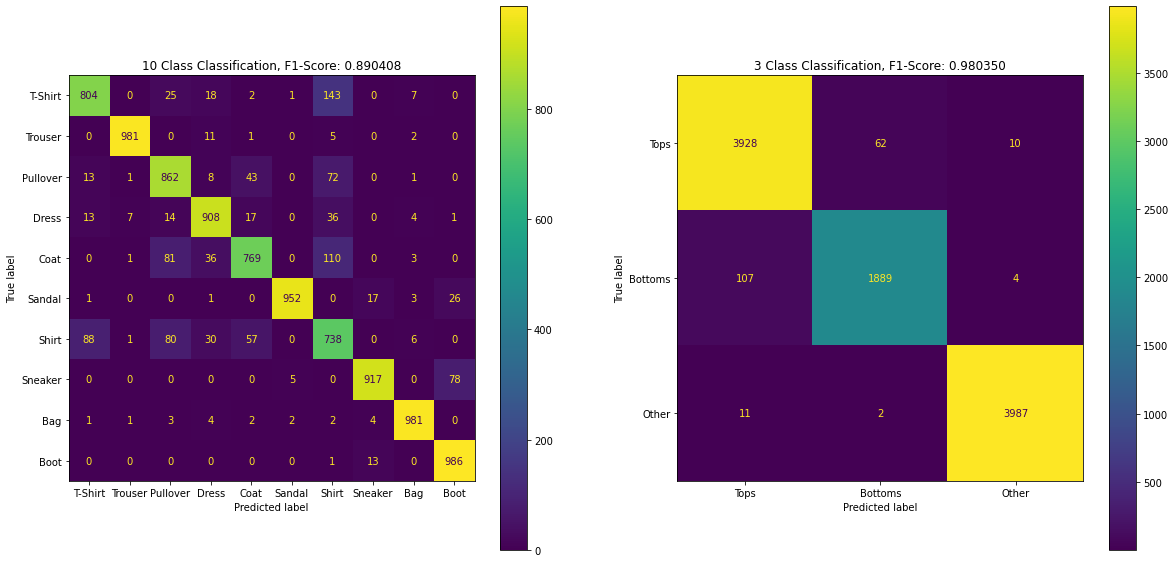

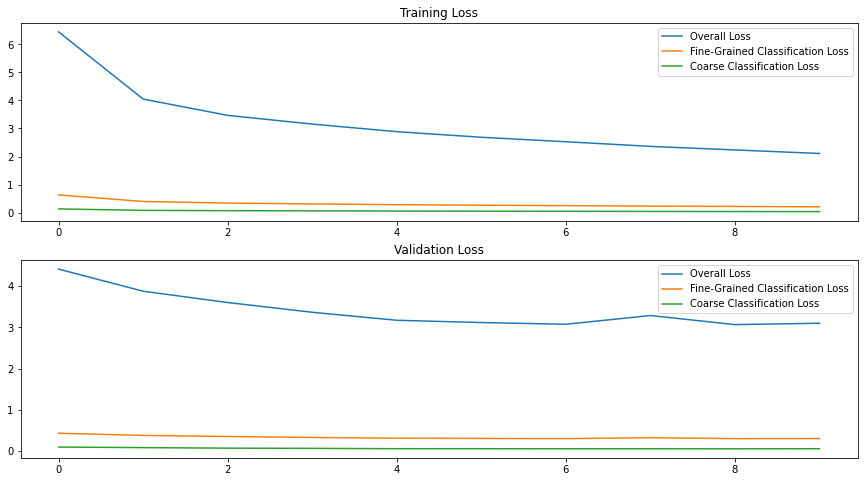

In [16]:
eval_model(multitask_cnn, x_test, y_test, y_test_simple, history)

## What is Learnt?

We've often visualised things, and typically we'll see some grouping of embeddings along class grounds. Here, we could reasonably expect to see a coarse grouping of our three classes, and then a sub-division within that into our 10-classes. Let's see if we actually get that.

In [17]:
encoder_output = multitask_cnn.get_layer('representation').output 
encoder_model = Model(inputs = multitask_cnn.input, outputs = encoder_output)
encoder_prediction = encoder_model.predict(x_test, verbose=False)

In [18]:
tsne_embeddings = TSNE(random_state=4).fit_transform(numpy.reshape(encoder_prediction, (-1, 1568)))

/home/simon/venvs/cab420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simon/venvs/cab420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


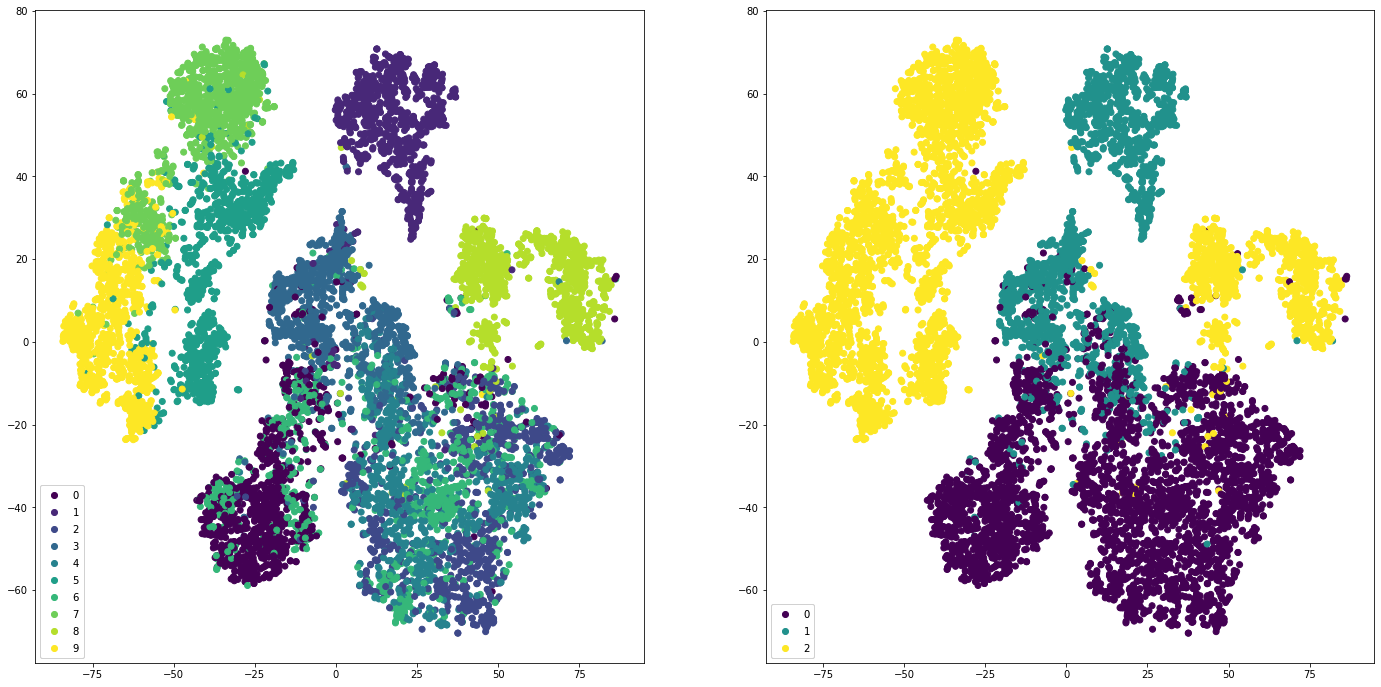

In [19]:
fig = plt.figure(figsize=[24, 12])
ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = tf.argmax(y_test, axis=1))
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left")
ax.add_artist(legend1)

ax = fig.add_subplot(1, 2, 2)
scatter = ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = tf.argmax(y_test_simple, axis=1))
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left")
ax.add_artist(legend1)

We get (more or less) what we expect. Looking at the coarse version we have three broad groupings, though with some fragmentation due to the diversity within the groups due to the different sub-classes. The most interesting of these is the third group (yellow) where the bulk of the points are on the left, with one smaller group on the right. Looking at the fine-grained t-SNE visualisation, we have the "bag" class as this lone group on the right, with the other three shoe classes grouped on the left. We also see with the coarse classes 0 (tops) and 1 (clothes other than tops) that we have two subgroups, and the one that overlaps most is the "dress" class (class 3 in the fine-grained plot), which makes a fair bit of sense.

All in all, the network is learning a representation very much in line with what's expected.

## Final Thoughts

In this example we've seen how we can use semi-supervised learning to learn from very limited data. 

The trick to all of this is a mask input that allows to basically ignore outputs that we don't have ground truth for. This way we only calculate the loss for the samples that we actually know. We can also change the weights of our losses to compensate for the fact that we have limited ground truth.

To do this however, we need to write a custom loss function that can exclude samples that don't have labels from consideration.

### Other tasks you could consider

In these situations you will also often see an autoencoder used as the "easy to annotate proxy task" (what can be easier than using the same data as the input). This, or using a similar unsupervised (or self-supervised) task is often a good choice. 

Previous iterations of this example have in fact done exactly that - but this has also caused confusion as people have then thought that for a semi-supervised task we *must* have an autoencoder. As such, this example has been switched up to use two classification tasks, but an autoencoder alongside the "fine-grained" task would be a very solid approach to take here.